In [404]:
import numpy as np
import matplotlib.pyplot as plt
import re
from itertools import combinations
import copy
%matplotlib inline

In [523]:
class Sudoku:
    def __init__(self, s):
        self.x = np.zeros([3]*4, dtype=int)
        self.default = np.zeros([3]*4, dtype=bool)
        tmp = list(map(int, re.findall("\d", s)))
        for i in range(9):
            for j in range(9):
                self.x[i//3, j//3, i%3, j%3] = tmp[i*9+j]
                self.default[i//3, j//3, i%3, j%3] = bool(tmp[i*9+j])
        self.draft = np.ones([3]*4+[9], dtype=bool)   # candidate if 1
        
    def initializeDraft(self):
        self.draft[np.where(self.x > 0)] = False
        # Normal
        for i in range(9):
            for j in range(9):
                v = self.x[i//3, j//3, i%3, j%3]
                if v != 0:
                    self.draft[i//3, :, i%3, :, v-1] = False  # row
                    self.draft[:, j//3, :, j%3, v-1] = False  # column
                    self.draft[i//3, j//3, :, :, v-1] = False # block
        # Only candidate
        for i in range(9):
            # row
            tmp = np.sum(self.draft[i//3, :, i%3, :], axis=(0, 1))
            for idx in np.where(tmp == 1)[0]:
                j, k = np.where(self.draft[i//3, :, i%3, :, idx])  # 
                self.draft[i//3, j, i%3, k, :] = False
                self.draft[i//3, j, i%3, k, idx] = True
            # column
            tmp = np.sum(self.draft[:, i//3, :, i%3], axis=(0, 1))
            for idx in np.where(tmp == 1)[0]:
                j, k = np.where(self.draft[:, i//3, :, i%3, idx])
                self.draft[j, i//3, k, i%3, :] = False
                self.draft[j, i//3, k, i%3, idx] = True
            # block
            tmp = np.sum(self.draft[i//3, i%3, :, :], axis=(0, 1))
            for idx in np.where(tmp == 1)[0]:
                j, k = np.where(self.draft[i//3, i%3, :, :, idx])
                self.draft[i//3, i%3, j, k, :] = False
                self.draft[i//3, i%3, j, k, idx] = True
        
    def updateDraftSimple(self):
        count_update = 1
        flag_update = False
        while count_update > 0:
            count_update = 0
            for i in range(9):
                for j in range(9):
                    if np.sum(self.draft[i//3, j//3, i%3, j%3]) == 1:
                        count_update += 1
                        flag_update = True
                        self.fill(i, j, np.where(self.draft[i//3, j//3, i%3, j%3])[0]+1)
        return flag_update
        
    def updateDraftHypothesis1(self):
        flag_update = False
        # single value
        # straight in block -> delete candidate in row, column
        for i in range(9):
            for k in range(9):
                tmp = np.where(self.draft[i//3, i%3, :, :, k])
                if tmp[0].shape[0] == 0:
                    continue
                # only cell in block
                if tmp[0].shape[0] == 1:
                    flag_update = True
                    self.draft[i//3, i%3, tmp[0][0], tmp[1][0]] = False
                    self.draft[i//3, i%3, tmp[0][0], tmp[1][0], k] = True
                # row
                if np.all(tmp[0] == tmp[0][0]):
                    flag_update = True
#                     print("block ({},{}), row {}, value {}".format(i//3, i%3, tmp[0][0], k+1))
                    self.draft[i//3, :, tmp[0][0], :, k] = False
                    for t in tmp[1]:
#                         print("Revive block ({},{}), ({},{}), value {}".format(i//3, i%3, tmp[0][0], t, k+1))
                        self.draft[i//3, i%3, tmp[0][0], t, k] = True
#                     self.plotTable()
#                     plt.show()
                # column
                if np.all(tmp[1] == tmp[1][0]):
                    flag_update = True
#                     print("block ({},{}), column {}, value {}".format(i//3, i%3, tmp[1][0], k+1))
                    self.draft[:, i%3, :, tmp[1][0], k] = False
                    for t in tmp[0]:
#                         print("Revive block ({},{}), ({},{}), value {}".format(i//3, i%3, t, tmp[1][0], k+1))
                        self.draft[i//3, i%3, t, tmp[1][0], k] = True
#                     self.plotTable()
#                     plt.show()
        # close in row -> delete candidate within block
        for i in range(9):
            for k in range(9):
                tmp = np.where(self.draft[i//3, :, i%3, :, k])
                if tmp[0].shape[0] == 0:
                    continue
                # only cell in row
                if tmp[0].shape[0] == 1:
                    flag_update = True
                    self.draft[i//3, tmp[0][0], i%3, tmp[1][0]] = False
                    self.draft[i//3, tmp[0][0], i%3, tmp[1][0], k] = True
                # block
                if np.all(tmp[0] == tmp[0][0]):
                    flag_update = True
#                     print("row {}, block ({},{}), value {}".format(i, i//3, tmp[0][0], k+1))
                    self.draft[i//3, tmp[0][0], :, :, k] = False
                    for t in tmp[1]:
                        self.draft[i//3, tmp[0][0], i%3, t, k] = True
#                     self.plotTable()
#                     plt.show()
        # close in column -> delete candidate within block
        for i in range(9):
            for k in range(9):
                tmp = np.where(self.draft[:, i//3, :, i%3, k])
                if tmp[0].shape[0] == 0:
                    continue
                # only cell in column
                if tmp[0].shape[0] == 1:
                    flag_update = True
                    self.draft[tmp[0][0], i//3, tmp[1][0], i%3] = False
                    self.draft[tmp[0][0], i//3, tmp[1][0], i%3, k] = True
                # block
                if np.all(tmp[0] == tmp[0][0]):
                    flag_update = True
#                     print("column {}, block ({},{}), value {}".format(i, tmp[0][0], i//3, k+1))
                    self.draft[tmp[0][0], i//3, :, :, k] = False
                    for t in tmp[1]:
                        self.draft[tmp[0][0], i//3, t, i%3, k] = True
#                     self.plotTable()
#                     plt.show()
        return flag_update
        
    def updateDraftHypothesisMultiple(self, d, show=False):
        flag_update = False
        # same pair in block -> delete in block (delete in column & row if straight)
        for i in range(9):  # block
            idx = np.where(np.any(self.draft[i//3, i%3], axis=-1).flatten())[0]
            for c in combinations(idx, d):
                cand = np.vstack([self.draft[i//3, i%3, j//3, j%3] for j in c])
                tmp = np.any(cand, axis=0)
                tmp_sum = np.sum(cand, axis=-1)
                if np.sum(tmp) == d and min(tmp_sum) >= 2:
                    flag_update = True
#                     print("block ({},{}), value ({},{})".format(i//3, i%3, *(np.where(tmp)[0]+1)))
                    # block
#                     print("Ignore {},{}".format(*c))
                    for j in range(9):
                        if j not in c:
                            self.draft[i//3, i%3, j//3, j%3][tmp] = False
                    # row if straight
                    if all(map(lambda e: c[0]//3 == e//3, c[1:])):
                        for j in range(9):
                            if j // 3 != i % 3:
                                self.draft[i//3, j//3, c[0]//3, j%3][tmp] = False
                    # column if straight
                    if all(map(lambda e: c[0]%3 == e%3, c[1:])):
                        for j in range(9):
                            if j // 3 != i // 3:
                                self.draft[j//3, i%3, j%3, c[0]%3][tmp] = False
                    if show:
                        self.plotTable()
                        plt.show()
        # same pair in row -> delete in row
        for i in range(9):  # row
            idx = np.where(np.any(self.draft[i//3, :, i%3, :], axis=-1).flatten())[0]  # cell with candidate
            for c in combinations(idx, d):
                cand = np.vstack([self.draft[i//3, j//3, i%3, j%3] for j in c])
                tmp = np.any(cand, axis=0)
                tmp_sum = np.sum(cand, axis=-1)
                if np.sum(tmp) == d and min(tmp_sum) >= 2:
                    flag_update = True
#                     print("row {}, value ({},{})".format(i, *(np.where(tmp)[0]+1)))
                    for j in range(9):
                        if j not in c:
                            self.draft[i//3, j//3, i%3, j%3][tmp] = False
                    if show:
                        self.plotTable()
                        plt.show()
        # same pair in column -> delete in column
        for i in range(9):  # row
            idx = np.where(np.any(self.draft[:, i//3, :, i%3], axis=-1).flatten())[0]  # cell with candidate
            for c in combinations(idx, d):
                cand = np.vstack([self.draft[j//3, i//3, j%3, i%3] for j in c])
                tmp = np.any(cand, axis=0)
                tmp_sum = np.sum(cand, axis=-1)
                if np.sum(tmp) == d and min(tmp_sum) >= 2:
                    flag_update = True
#                     print("column {}, value ({},{})".format(i, *(np.where(tmp)[0]+1)))
                    for j in range(9):
                        if j not in c:
                            self.draft[j//3, i//3, j%3, i%3][tmp] = False
                    if show:
                        self.plotTable()
                        plt.show()
        return flag_update
                            
    def initialize(self):
        self.initializeDraft()
        self.updateDraftSimple()
        
    def play(self, show=False):
        flag_update = True
        while flag_update and self.isValid():
            if not np.any(self.draft):
                break
            flag_update = False
            self.updateDraftHypothesis1()
            self.updateDraftHypothesisMultiple(2)
            self.updateDraftHypothesisMultiple(3)
            flag_update |= self.updateDraftSimple()
            if show:
                self.plotTable()
                plt.show()
        # Needs hypothesis
        if np.any(self.draft):
            cand = np.sum(self.draft, axis=-1)
            i1, j1, i2, j2 = map(lambda e: e[0], np.where(cand == np.min(cand[cand > 0])))
            i, j = i1*3+i2, j1*3+j2
            for k in np.where(self.draft[i1, j1, i2, j2])[0]:
#                 print(f"Try {k+1} to ({i},{j}) ")
                phantom = copy.deepcopy(self)
                phantom.fill(i, j, k+1)
                phantom.play(show)
                if phantom.isValid():
                    self.x = phantom.x.copy()
                    self.draft = phantom.draft.copy()
                    break
        
    def plotTable(self):
        fig = plt.figure(figsize=(8, 8))
        plt.xticks([])
        plt.yticks([])
        plt.xlim([-0.5, 8.5])
        plt.ylim([8.5, -0.5])
        for i in range(1, 9):
            lw = .7 if i % 3 else 2.5
            plt.plot([-0.5, 8.5], [i-0.5, i-0.5], "k-", lw=lw)  # horizontal
            plt.plot([i-0.5, i-0.5], [-0.5, 8.5], "k-", lw=lw)  # vertical
        for i in range(9):
            for j in range(9):
                if self.x[i//3, j//3, i%3, j%3] != 0:
                    c = "black" if self.default[i//3, j//3, i%3, j%3] else "blue"
                    plt.text(j, i, str(self.x[i//3, j//3, i%3, j%3]), 
                             horizontalalignment="center", verticalalignment="center", fontsize=24, color=c)
                else:
                    for k in range(9):
                        if self.draft[i//3, j//3, i%3, j%3, k]:
                            plt.text(j+((k%3)-1)/4, i+((k//3)-1)/4, 
                                     str(k+1), 
                                     horizontalalignment="center", verticalalignment="center", fontsize=10, color="gray")

    def isValid(self):
        m = np.zeros([3]*4+[9], dtype=bool)
        for i in range(9):
            for j in range(9):
                v = self.x[i//3, j//3, i%3, j%3]
                if v == 0:
                    if not np.any(self.draft[i//3, j//3, i%3, j%3]):
#                         print("Invalid: ({},{})".format(i, j))
                        return False
                    continue
                if m[i//3, j//3, i%3, j%3, v-1]:
#                     print("Invalid: ({},{})".format(i, j))
                    return False
                m[i//3, :, i%3, :, v-1] = True
                m[:, j//3, :, j%3, v-1] = True
                m[i//3, j//3, :, :, v-1] = True
        return True
    
    def fill(self, i, j, v):
        if self.draft[i//3, j//3, i%3, j%3, v-1]:
            self.x[i//3, j//3, i%3, j%3] = v
            self.draft[i//3, j//3, i%3, j%3] = False  # self element
            self.draft[i//3, :, i%3, :, v-1] = False  # row
            self.draft[:, j//3, :, j%3, v-1] = False  # column
            self.draft[i//3, j//3, :, :, v-1] = False # block
        else:
            print("{} is not a candidate in ({}, {})".format(v, i, j))
    
    def __call__(self):
        self.plotTable()

True


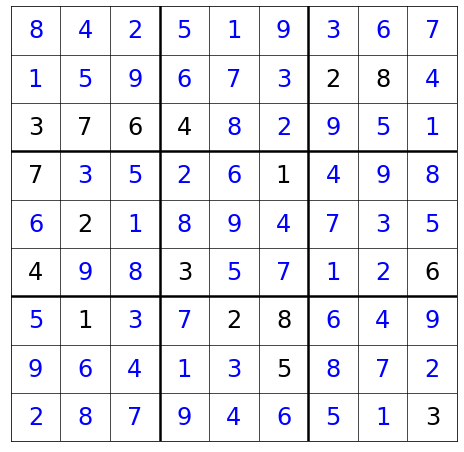

In [524]:
s = """
000000000
000000280
376400000
700001000
020000000
400300006
010028000
000005000
000000003
"""
model = Sudoku(s)
model.initialize()
model.play()
print(model.isValid())
model.plotTable()

True


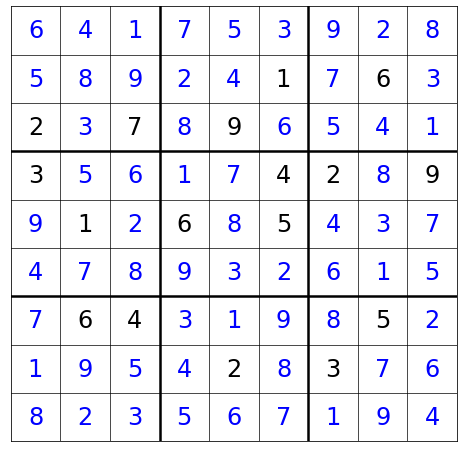

In [525]:
s = """
000000000
000001060
207090000
300004209
010605000
000000000
064000050
000020300
000000000
"""
model = Sudoku(s)
model.initialize()
model.play()
print(model.isValid())
model.plotTable()